# Part 1


In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)


2.2.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [38]:
df = pd.read_csv('/content/project/maotai_600519.csv')
df

,Unnamed: 0,secID,ticker,secShortName,exchangeCD,tradeDate,preClosePrice,actPreClosePrice,openPrice,highestPrice,lowestPrice,closePrice,turnoverVol,turnoverValue,dealAmount,turnoverRate,accumAdjFactor,negMarketValue,marketValue,chgPct,PE,PE1,PB,isOpen,vwap
0,0,600519.XSHG,600519,贵州茅台,XSHG,2015-01-05,189.62,189.62,189.62,204.24,188.69,202.52,9451517,1875063136,27209,0.0083,0.83693,231277434960,231277434960,0.0680,15.0671,15.0671,4.3286,1,198.388
1,1,600519.XSHG,600519,贵州茅台,XSHG,2015-01-06,202.52,202.52,200.00,202.56,196.02,197.83,5502001,1094977375,16677,0.0048,0.83693,225921464340,225921464340,-0.0232,14.7182,14.7182,4.2283,1,199.014
2,2,600519.XSHG,600519,贵州茅台,XSHG,2015-01-07,197.83,197.83,196.04,199.50,189.99,192.94,5479784,1063925641,17690,0.0048,0.83693,220337094120,220337094120,-0.0247,14.3544,14.3544,4.1238,1,194.155
3,3,600519.XSHG,600519,贵州茅台,XSHG,2015-01-08,192.94,192.94,194.00,194.52,190.14,191.76,4052530,777874670,14646,0.0035,0.83693,218989536480,218989536480,-0.0061,14.2666,14.2666,4.0986,1,191.948
4,4,600519.XSHG,600519,贵州茅台,XSHG,2015-01-09,191.76,191.76,190.40,195.77,190.11,190.31,5398220,1039955153,17621,0.0047,0.83693,217333639380,217333639380,-0.0076,14.1587,14.1587,4.0676,1,192.648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,1214,600519.XSHG,600519,贵州茅台,XSHG,2019-12-25,1148.00,1148.00,1143.00,1143.00,1130.01,1133.70,2430597,2755735164,14387,0.0019,1.00000,1424151445860,1424151445860,-0.0125,34.7991,35.0720,11.3697,1,1133.769
1215,1215,600519.XSHG,600519,贵州茅台,XSHG,2019-12-26,1133.70,1133.70,1132.00,1141.98,1119.99,1135.10,2287727,2585996501,13365,0.0018,1.00000,1425910122780,1425910122780,0.0012,34.8421,35.1153,11.3838,1,1130.378
1216,1216,600519.XSHG,600519,贵州茅台,XSHG,2019-12-27,1135.10,1135.10,1150.00,1172.00,1150.00,1163.00,4706628,5486452901,27166,0.0037,1.00000,1460958041400,1460958041400,0.0246,35.6985,35.9785,11.6636,1,1165.687
1217,1217,600519.XSHG,600519,贵州茅台,XSHG,2019-12-30,1163.00,1163.00,1170.20,1195.50,1170.20,1185.80,4076066,4827682057,24313,0.0032,1.00000,1489599351240,1489599351240,0.0196,36.3983,36.6838,11.8922,1,1184.397


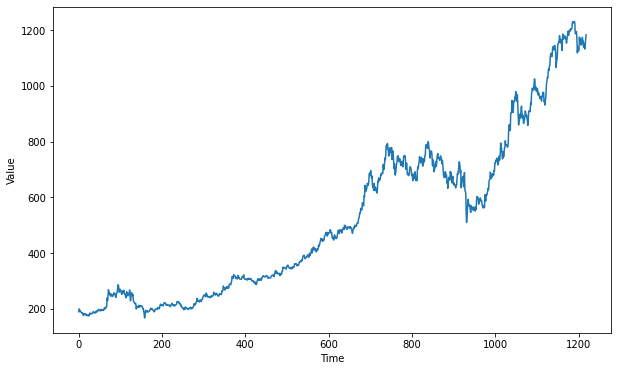

In [48]:
series = df['openPrice'].to_numpy()
time = np.array(df.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [67]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  # tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/50
31/31 [==============================] - 0s 16ms/step - loss: 349.6429 - mae: 350.1429 - lr: 1.0000e-08
Epoch 2/50
31/31 [==============================] - 0s 16ms/step - loss: 339.1537 - mae: 339.6537 - lr: 1.1220e-08
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 316.8854 - mae: 317.3854 - lr: 1.2589e-08
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 295.0041 - mae: 295.5041 - lr: 1.4125e-08
Epoch 5/50
31/31 [==============================] - 1s 17ms/step - loss: 283.5259 - mae: 284.0260 - lr: 1.5849e-08
Epoch 6/50
31/31 [==============================] - 1s 17ms/step - loss: 273.7211 - mae: 274.2210 - lr: 1.7783e-08
Epoch 7/50
31/31 [==============================] - 1s 16ms/step - loss: 262.2570 - mae: 262.7566 - lr: 1.9953e-08
Epoch 8/50
31/31 [==============================] - 1s 16ms/step - loss: 243.9034 - mae: 244.

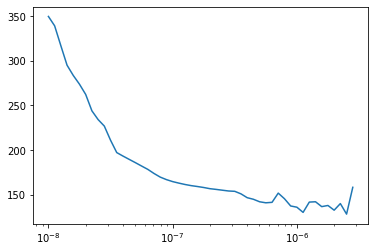

In [68]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])

In [57]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500,verbose=0)

Epoch 1/500
10/10 [==============================] - 1s 112ms/step - loss: 321.9422 - mae: 322.4420
Epoch 2/500
10/10 [==============================] - 1s 113ms/step - loss: 178.7266 - mae: 179.2262
Epoch 3/500
10/10 [==============================] - 1s 112ms/step - loss: 180.3540 - mae: 180.8536
Epoch 4/500
10/10 [==============================] - 1s 112ms/step - loss: 170.7418 - mae: 171.2414
Epoch 5/500
10/10 [==============================] - 1s 112ms/step - loss: 166.8227 - mae: 167.3223
Epoch 6/500
10/10 [==============================] - 1s 113ms/step - loss: 166.1202 - mae: 166.6195
Epoch 7/500
10/10 [==============================] - 1s 112ms/step - loss: 164.4174 - mae: 164.9170
Epoch 8/500
10/10 [==============================] - 1s 113ms/step - loss: 161.5793 - mae: 162.0789
Epoch 9/500
10/10 [==============================] - 1s 110ms/step - loss: 160.8778 - mae: 161.3773
Epoch 10/500
10/10 [==============================] - 1s 111ms/step - loss: 160.8849 - mae: 161.3843

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

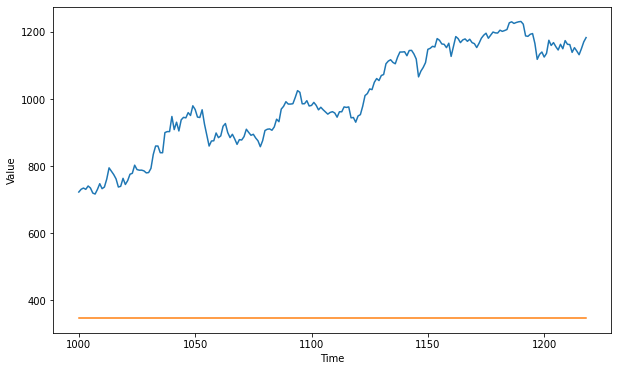

In [64]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

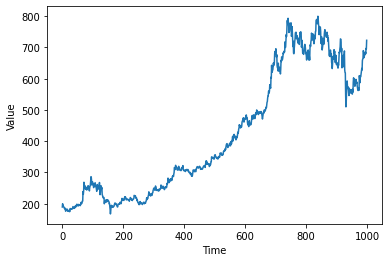

In [69]:
plot_series(time[:split_time], x_train)

# part 2


In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [135]:
uni_data = df['openPrice']
uni_data.index = df['tradeDate']
uni_data.head()

tradeDate
2015-01-05    189.62
2015-01-06    200.00
2015-01-07    196.04
2015-01-08    194.00
2015-01-09    190.40
Name: openPrice, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d13fe2400>],
      dtype=object)

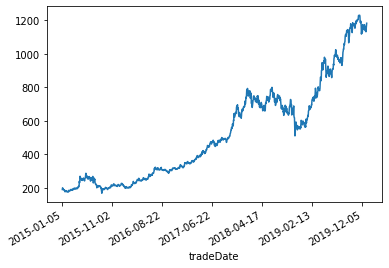

In [136]:
uni_data.plot(subplots=True)

In [0]:
TRAIN_SPLIT = 1000
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [142]:
TRAIN_SPLIT = 1000
tf.random.set_seed(13)

uni_data = df['openPrice']
uni_data.index = df['tradeDate']
uni_data.head()

tradeDate
2015-01-05    189.62
2015-01-06    200.00
2015-01-07    196.04
2015-01-08    194.00
2015-01-09    190.40
Name: openPrice, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d13efcd30>],
      dtype=object)

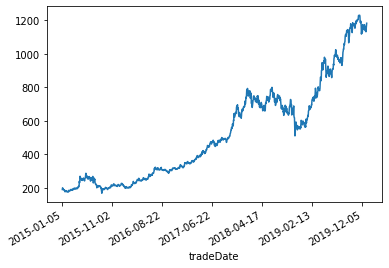

In [143]:
uni_data.plot(subplots=True)

In [146]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Open price to predict')
print (y_train_uni[0])

Single window of past history
[[-1.15956636]
 [-1.10706088]
 [-1.12709187]
 [-1.13741087]
 [-1.15562086]
 [-1.1576442 ]
 [-1.17281919]
 [-1.18293586]
 [-1.18855061]
 [-1.17686586]
 [-1.20316919]
 [-1.22835968]
 [-1.21697843]
 [-1.19623927]
 [-1.20762052]
 [-1.19962835]
 [-1.19396302]
 [-1.21328585]
 [-1.22744918]
 [-1.2234531 ]]

 Open price to predict
-1.2309394313257471


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

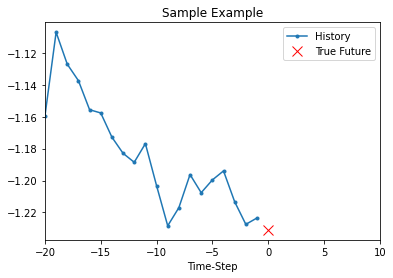

In [148]:
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

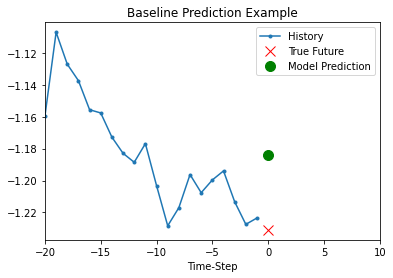

In [149]:
def baseline(history):
  return np.mean(history)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')


In [152]:
# RNN model 
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

(199, 1)
Epoch 1/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2407 - val_loss: 1.3886
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0616 - val_loss: 1.1781
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0518 - val_loss: 1.0158
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0459 - val_loss: 0.8761
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0422 - val_loss: 0.7795
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0402 - val_loss: 0.7192
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0389 - val_loss: 0.6721
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0377 - val_loss: 0.6330
Epoch 9/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0367 - val_loss: 0.5932
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0358

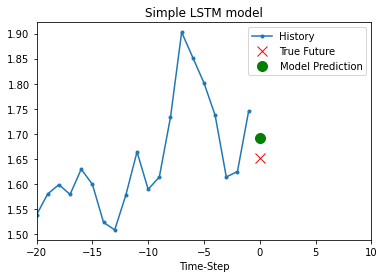

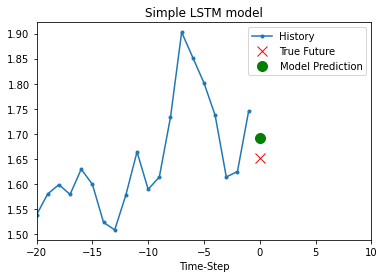

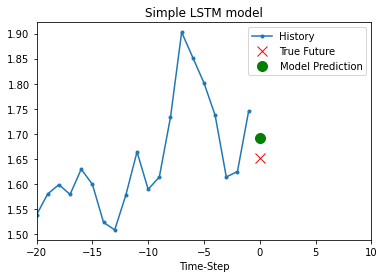

In [153]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

# -----------------


In [83]:
features_considered = ['openPrice', 'turnoverVol']
features = df[features_considered]
features.index = df['tradeDate']
features.head()

,openPrice,turnoverVol
tradeDate,,
2015-01-05,189.62,9451517
2015-01-06,200.00,5502001
2015-01-07,196.04,5479784
2015-01-08,194.00,4052530
2015-01-09,190.40,5398220


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d13cab518>,
      dtype=object)

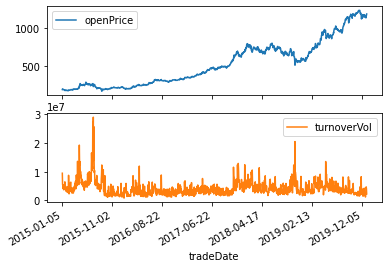

In [154]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [0]:
# Single step model
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 60
future_target = 7
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [184]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (60, 2)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [187]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(152, 1)


In [188]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 11s 53ms/step - loss: 0.5108 - val_loss: 0.6335
Epoch 2/10
200/200 [==============================] - 10s 52ms/step - loss: 0.4643 - val_loss: 0.7452
Epoch 3/10
200/200 [==============================] - 10s 52ms/step - loss: 0.4383 - val_loss: 0.7673
Epoch 4/10
200/200 [==============================] - 10s 52ms/step - loss: 0.4234 - val_loss: 0.8003
Epoch 5/10
200/200 [==============================] - 10s 51ms/step - loss: 0.4111 - val_loss: 0.8041
Epoch 6/10
200/200 [==============================] - 10s 51ms/step - loss: 0.4047 - val_loss: 0.8804
Epoch 7/10
200/200 [==============================] - 10s 51ms/step - loss: 0.3975 - val_loss: 0.9762
Epoch 8/10
200/200 [==============================] - 10s 51ms/step - loss: 0.3926 - val_loss: 1.0345
Epoch 9/10
200/200 [==============================] - 11s 53ms/step - loss: 0.3867 - val_loss: 1.1048
Epoch 10/10
200/200 [==============================] - 10s 52ms/step - loss: 0.382

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

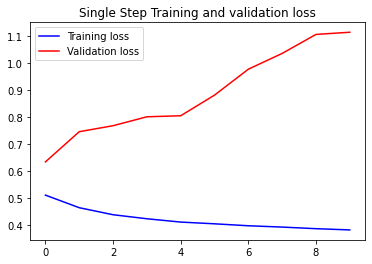

In [190]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

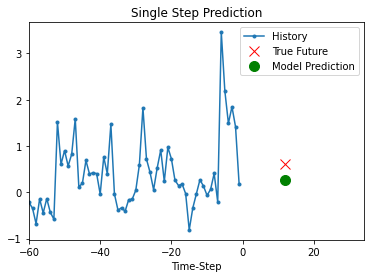

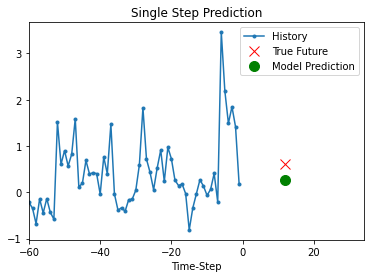

In [191]:
for x, y in val_data_single.take(2):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
# multistep model 
future_target = 7
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [194]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target Open Price to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 2)

 Target Open Price to predict : (7,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

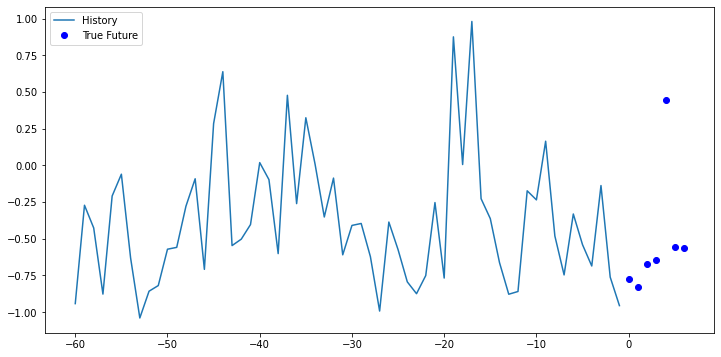

In [197]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(7))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [199]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)


(152, 7)


In [200]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 19s 94ms/step - loss: 0.5142 - val_loss: 0.4735
Epoch 2/10
200/200 [==============================] - 19s 93ms/step - loss: 0.4448 - val_loss: 0.5209
Epoch 3/10
200/200 [==============================] - 18s 91ms/step - loss: 0.4178 - val_loss: 0.5804
Epoch 4/10
200/200 [==============================] - 19s 93ms/step - loss: 0.4053 - val_loss: 0.7597
Epoch 5/10
200/200 [==============================] - 18s 92ms/step - loss: 0.3965 - val_loss: 0.7066
Epoch 6/10
200/200 [==============================] - 18s 92ms/step - loss: 0.3890 - val_loss: 0.9014
Epoch 7/10
200/200 [==============================] - 18s 92ms/step - loss: 0.3810 - val_loss: 0.8206
Epoch 8/10
200/200 [==============================] - 19s 93ms/step - loss: 0.3718 - val_loss: 0.7761
Epoch 9/10
200/200 [==============================] - 19s 93ms/step - loss: 0.3613 - val_loss: 0.8511
Epoch 10/10
200/200 [==============================] - 19s 94ms/step - loss: 0.352

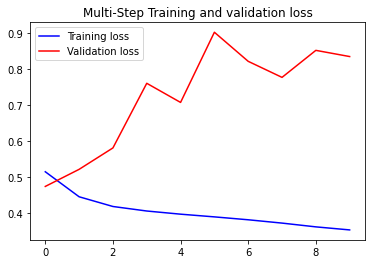

In [201]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

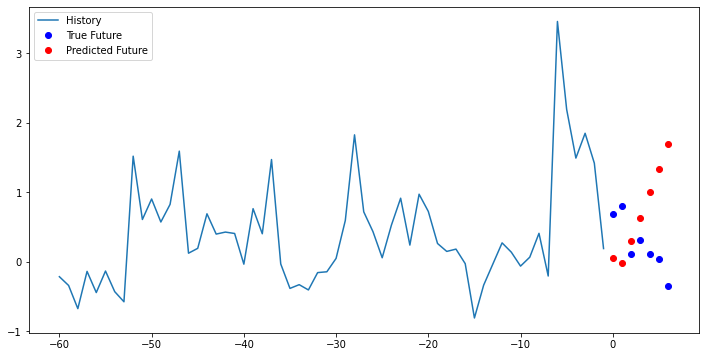

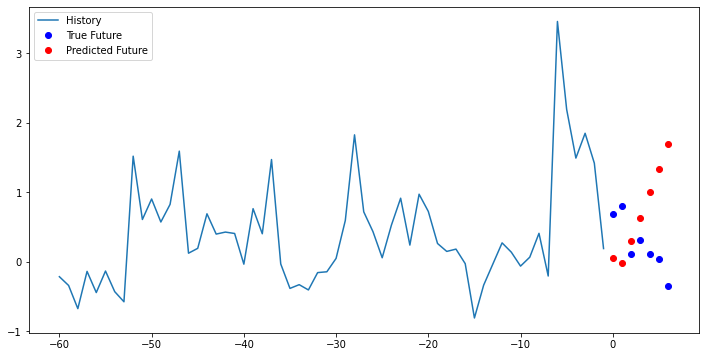

In [202]:
for x, y in val_data_multi.take(2):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])